In [1]:
# importing libraries
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

# reading the data
df = pd.read_csv('https://raw.githubusercontent.com/dipanshuagarwal/Stock-Market-Forecasting/master/Dataset/dataset11-19.csv')

# looking at the first five rows of the data
print(df.head())
print('\n Shape of the data:')
print(df.shape)

#setting index as date values
df['Date'] = pd.to_datetime(df.Date,format='%d-%m-%Y')
df.index = df['Date']

#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:1981,:]
valid = dataset[1981:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

Using TensorFlow backend.


         Date   Open   High     Low   Close   Volume
0  31-12-2019  334.9  336.3  332.60  333.70   744106
1  30-12-2019  337.8  337.9  332.45  334.25   860732
2  27-12-2019  333.6  338.3  333.05  337.25  1249101
3  26-12-2019  333.0  333.2  328.05  329.85   660165
4  24-12-2019  332.7  334.2  329.25  331.30   750326

 Shape of the data:
(2226, 6)
Epoch 1/1
 - 68s - loss: 0.0024


In [2]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
print('\n RMS value on validation set:')
print(rms)

mape=np.mean(abs(closing_price-valid))
print('\n MAPE value on validation set:')
print(mape)


 RMS value on validation set:
13.225374206541055

 MAPE value on validation set:
11.279417786890136


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


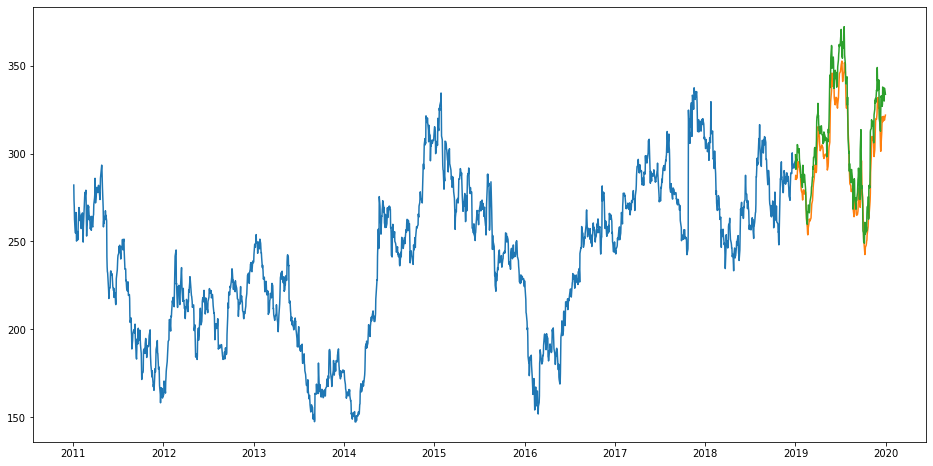

In [4]:
#for plotting
train = new_data[:1981]
valid = new_data[1981:]
valid['Predictions'] = closing_price
plt.figure(figsize=(16,8))
plt.plot(train['Close'])
plt.plot(valid[['Predictions','Close']])